In [17]:
import pandas as pd
import numpy as np
from utils.io import read_netts
from utils.data_functions import compute_SWC
from utils.plotting import plot_matrix, plot_2d_scatter, plot_3d_scatter
from utils.basics import PNAS2015_subject_list, PRJ_DIR
from utils.basics import task_cmap_caps as task_cmap
import os.path as osp
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors    import kneighbors_graph
from sklearn.utils import check_random_state
from utils.random import seed_value

In [102]:
import plotly.express as px
import panel as pn
camera = dict( up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=2, y=2, z=1))
scene_correct_le = dict(
        xaxis = dict(nticks=1, gridcolor="rgb(230,230,230)", showbackground=True, zerolinecolor="white",backgroundcolor='rgb(230,230,230)'),
        yaxis = dict(nticks=1, gridcolor="rgb(230,230,230)", showbackground=True, zerolinecolor="white",backgroundcolor='rgb(230,230,230)'),
        zaxis = dict(nticks=1, gridcolor="rgb(230,230,230)", showbackground=True, zerolinecolor="white",backgroundcolor='rgb(230,230,230)'))
 
def plot_3d_scatter(data,x,y,z,c,cds):
    fig = px.scatter_3d(data,
                        x=x,y=y,z=z, 
                        width=300, height=300, 
                        opacity=0.3, color=c,color_discrete_sequence=cds)
    fig.update_layout(showlegend=False, 
                          font_color='white', scene_aspectmode='cube');
    fig.update_layout(scene=scene_correct_le, margin=dict(l=2, r=2, b=0, t=0, pad=0))
    fig.update_traces(marker_size = 1)
    return fig

### Load the window labels (when using all windows)

In [3]:
win_labels = np.loadtxt('/data/SFIMJGC_HCP7T/manifold_learning_fmri/Resources/Figure01/winlabels_wl030_ws001.csv', dtype='str')
print('++ INFO: Number of available window labels: %d' % len(win_labels))

++ INFO: Number of available window labels: 988


### Load all the tvFC matrics, z-scored them and then concatenate them

The next cell will create two different versions of a group-level tvFC matrix:

* **"AsIs"**: it simply loads and concatenate pre-computed scan-level tvFC.Z matrices into a single matrix of size (Ncons *(N_scans * N_wins))
* **"Zscored"**: same as above, except that prior to contanetaing, each scan matrix is first Z-scored (features)

In [4]:
%%time
group_tvFCs = {'asis':pd.DataFrame(),
               'zscored': pd.DataFrame()}
for sbj in tqdm(PNAS2015_subject_list,desc='Subjects'):
    tvFC_path = osp.join(PRJ_DIR,'Data_Interim','PNAS2015',sbj,'{sbj}_Craddock_0200.WL045s.WS1.5s.tvFC.Z.pkl'.format(sbj=sbj))
    tvFC = pd.read_pickle(tvFC_path)
    # Without normalization
    group_tvFCs['asis']    = pd.concat([group_tvFCs['asis'],tvFC],axis=1)
    # Normalize tvFC (subject-by-subject)
    zscored_tvFC           = tvFC.copy()
    zscored_tvFC           = zscored_tvFC.apply(zscore,1)
    group_tvFCs['zscored'] = pd.concat([group_tvFCs['zscored'],zscored_tvFC],axis=1)

Subjects:   0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 7min 47s, sys: 9.53 s, total: 7min 56s
Wall time: 7min 59s


In [5]:
out_dir = osp.join(PRJ_DIR,'Data_Interim','PNAS2015','ALL')
if not osp.exists(out_dir):
    print("+ Create output folder: %s" % out_dir)
    os.makedirs(out_dir)

Before saving to disk, we will add the subject and task info to the colum of the dataframe

In [6]:
[N_cons, N_wins]=tvFC.shape
sbj_labels = []
for s in PNAS2015_subject_list:
    sbj_labels = sbj_labels + list(np.tile(s,N_wins))
win_labels = group_tvFCs['asis'].columns
column_names = pd.MultiIndex.from_arrays([sbj_labels,win_labels],names=['Subject','Window Name'])

In [7]:
for scenario in ['asis','zscored']:
    group_tvFCs[scenario].columns    = column_names
    group_tvFCs[scenario].index.name = 'Connections'

The two group matrices are saved to disk
* **"AsIs"**: ```/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/AL/ALL_Craddock_0200.WL045s.WS1.5s.tvFC.Z.asis.pkl```
* **"Zscored"**: ```/data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/Group/ALL_Craddock_0200.WL045s.WS1.5s.tvFC.Z.zscored.pkl```

In [9]:
%%time
for scenario in ['asis','zscored']:
    group_tvFC_path = osp.join(out_dir,'ALL_Craddock_0200.WL045s.WS1.5s.tvFC.Z.{scenario}.pkl'.format(scenario=scenario))
    group_tvFCs[scenario].to_pickle(group_tvFC_path)
    print('++ INFO: Size of %s Group-level Matrix [%s] | Save to %s' % (scenario,str(group_tvFCs[scenario].shape),group_tvFC_path))

++ INFO: Size of asis Group-level Matrix [(12246, 19760)] | Save to /data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/Group/ALL_Craddock_0200.WL045s.WS1.5s.tvFC.Z.asis.pkl
++ INFO: Size of zscored Group-level Matrix [(12246, 19760)] | Save to /data/SFIMJGC_HCP7T/manifold_learning_fmri/Data_Interim/PNAS2015/Group/ALL_Craddock_0200.WL045s.WS1.5s.tvFC.Z.zscored.pkl
CPU times: user 1.76 s, sys: 1.44 s, total: 3.2 s
Wall time: 3.7 s


***

### Create Representative Embeddings with each of the 3 techniques for a first exploration of this approach

### 1. Laplacian EigenMaps

In [10]:
m=3
knn=100

In [11]:
random_state    = check_random_state(seed_value)
LE_objs = {'asis':SpectralEmbedding(n_components=m, affinity='precomputed', n_jobs=-1, random_state=random_state),
           'zscored':SpectralEmbedding(n_components=m, affinity='precomputed', n_jobs=-1, random_state=random_state)}

In [14]:
%%time
Xaffs = {}
for scenario in tqdm(['asis','zscored'], desc='Scenarios'):
    Xaff_non_sym = pd.DataFrame(kneighbors_graph(group_tvFCs[scenario].T, 
                                               n_neighbors  = knn, 
                                               include_self = False, 
                                               n_jobs       = -1, 
                                               metric       = 'correlation',
                                               mode='connectivity').toarray())
    
    # Symmetrization is done as in sklearn (for compatibility) 
    Xaffs[scenario] = 0.5 * (Xaff_non_sym + Xaff_non_sym.T)
    # If we wanted to implement the original description by Belkin et al. we would use the following:
    #Xaff = ((0.5 * (Xaff_non_symmetric + Xaff_non_symmetric.T)) > 0).astype(int)
    print(" + Affinity matrix shape [%s]: %s" % (scenario,str(Xaffs[scenario].shape)))

 + Affinity matrix shape [asis]: (19760, 19760)
 + Affinity matrix shape [zscored]: (19760, 19760)
CPU times: user 9h 52min 28s, sys: 2min 10s, total: 9h 54min 39s
Wall time: 19min 9s


In [20]:
%%time
le_embs = {}
for scenario in tqdm(['asis','zscored'], desc='Scenarios'):
    aux                 = LE_objs[scenario].fit_transform(Xaffs[scenario])
    dim_labels          = ['LE'+str(i+1).zfill(3) for i in range(m)]
    aux_df              = pd.DataFrame(aux, columns=dim_labels)
    aux_df.columns.name = 'LE dimensions'
    aux_df.index        = group_tvFCs[scenario].columns
    aux_df.index.name   = 'Window Name'
    le_embs[scenario]   = aux_df

Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 19min 4s, sys: 19min 9s, total: 38min 13s
Wall time: 4min 7s


In [128]:
dfs_ready2plot = {'asis':le_embs['asis'].drop('XXXX',level='Window Name').reset_index(),
                  'zscored':le_embs['zscored'].drop('XXXX',level='Window Name').reset_index()}
task_colors   = [task_cmap[t] for t in dfs_ready2plot['asis']['Window Name'].unique()]
sbj_colors    = px.colors.qualitative.Light24[0:20]
sbj_cmap = {PNAS2015_subject_list[i]:sbj_colors[i] for i in range(len(PNAS2015_subject_list))}

In [130]:
(plot_2d_scatter(dfs_ready2plot['asis'],x='LE001',y='LE002',c='Window Name') + plot_2d_scatter(dfs_ready2plot['asis'],x='LE001',y='LE002',c='Subject', cmap=sbj_cmap) + \
plot_2d_scatter(dfs_ready2plot['zscored'],x='LE001',y='LE002',c='Window Name') + plot_2d_scatter(dfs_ready2plot['zscored'],x='LE001',y='LE002',c='Subject', cmap=sbj_cmap)).cols(2)

:Layout
   .Scatter.I   :Scatter   [LE001]   (LE002,Window Name)
   .Scatter.II  :Scatter   [LE001]   (LE002,Subject)
   .Scatter.III :Scatter   [LE001]   (LE002,Window Name)
   .Scatter.IV  :Scatter   [LE001]   (LE002,Subject)

In [115]:
df_to_plot    = le_embs['asis'].drop('XXXX',level='Window Name').reset_index()
task_colors   = [task_cmap[t] for t in df_to_plot['Window Name'].unique()]
as_is_cb_sbj  = plot_3d_scatter(df_to_plot,x='LE001',y='LE002',z='LE003',c='Subject', cds=px.colors.qualitative.Light24[0:20])
as_is_cb_task = plot_3d_scatter(df_to_plot,x='LE001',y='LE002',z='LE003',c='Window Name', cds=task_colors)

{'REST': 'gray',
 'BACK': 'blue',
 'VIDE': '#F4D03F',
 'MATH': 'green',
 'XXXX': 'black'}

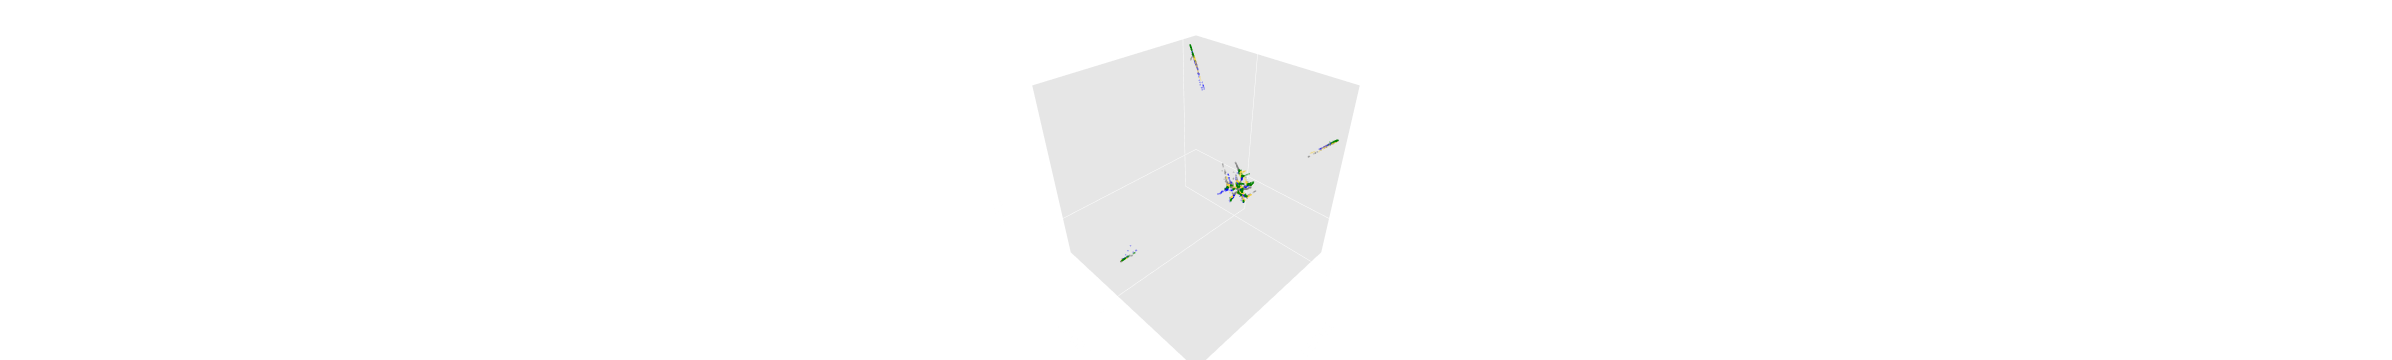

In [117]:
as_is_cb_task

In [110]:
df_to_plot    = le_embs['zscored'].drop('XXXX',level='Window Name').reset_index()
task_colors   = [task_cmap[t] for t in df_to_plot['Window Name'].unique()]
zscored_cb_sbj  = plot_3d_scatter(df_to_plot,x='LE001',y='LE002',z='LE003',c='Subject', cds=px.colors.qualitative.Light24[0:20])
zscored_cb_task = plot_3d_scatter(df_to_plot,x='LE001',y='LE002',z='LE003',c='Window Name', cds=task_colors)

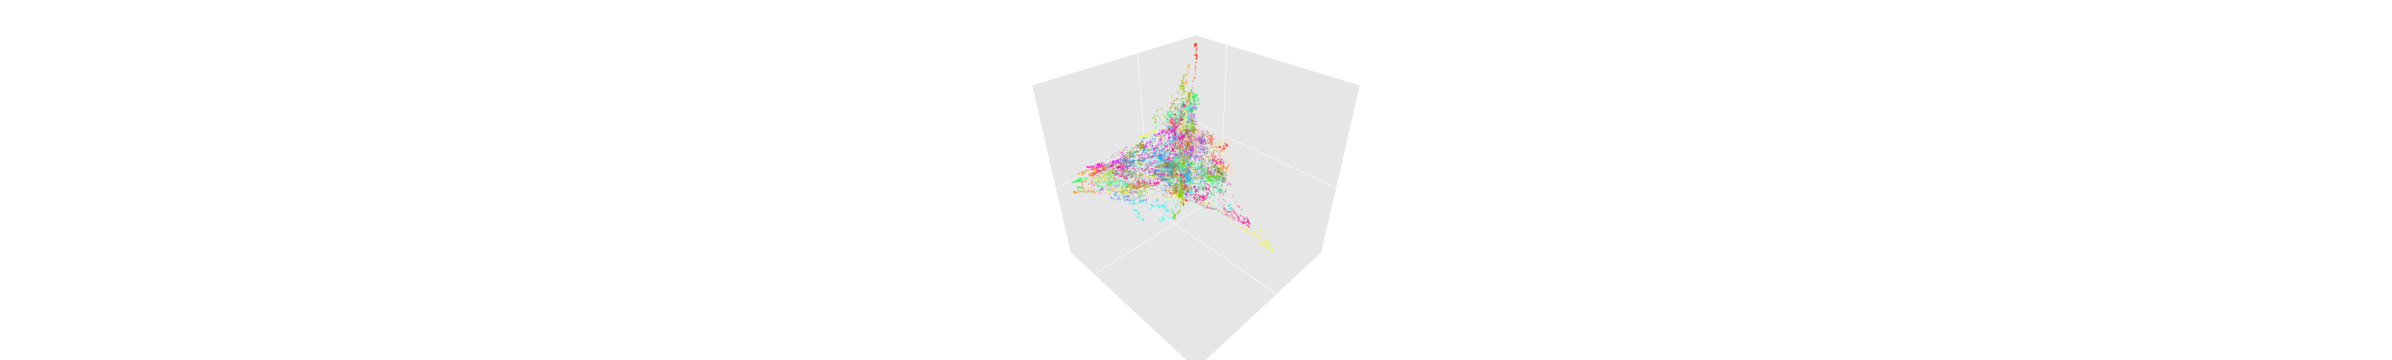

In [111]:
zscored_cb_sbj

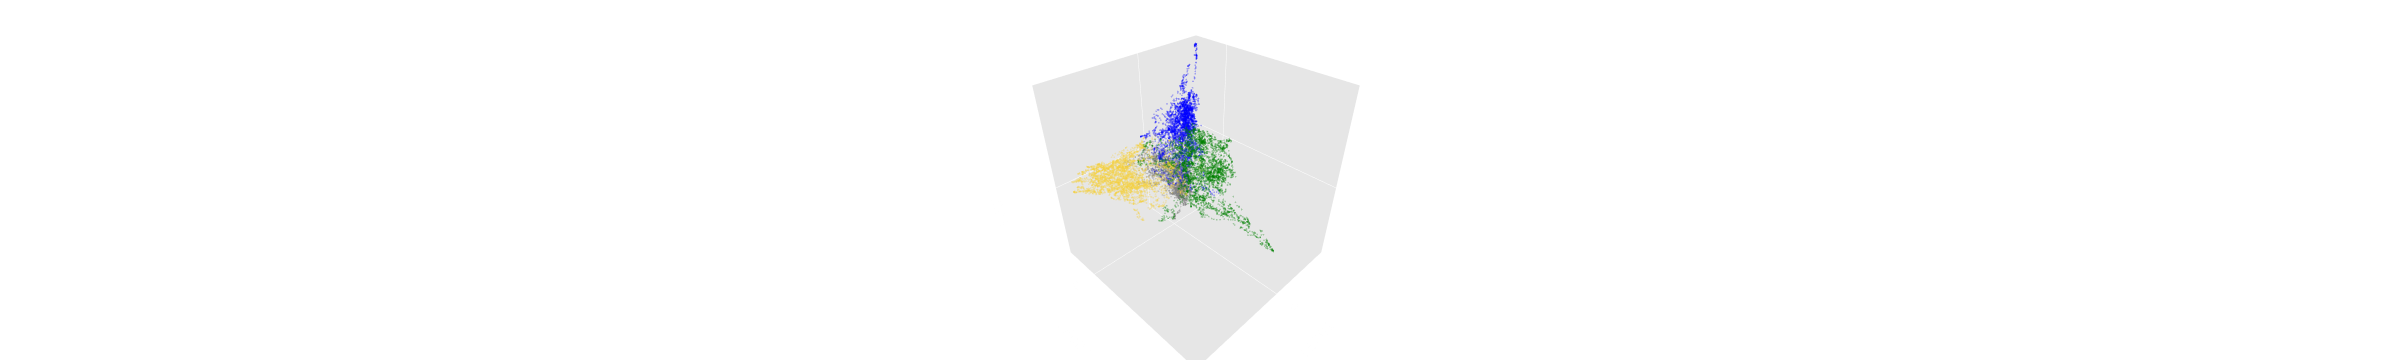

In [112]:
zscored_cb_task

In [119]:
plot_2d_scatter(le_embs['asis'],x='LE001',y='LE002',c='Subject')

KeyError: 'Subject'

In [60]:
plot_3d_scatter(df.reset_index(),x='LE001',y='LE002',z='LE003',cds=[task_cmap[t] for t in df.reset_index()['Window Name'].unique()])

NameError: name 'df' is not defined

In [16]:
group_tvFC.shape

(12246, 1976)

In [ ]:
group_tvFC = pd.DataFrame()
for sbj in tqdm(PNAS2015_subject_list,desc='Subjects'):
    ts_path = osp.join(PRJ_DIR,'Data','PNAS2015',sbj,'{sbj}_Craddock_0200.WL045s_000.netts'.format(sbj=sbj))
    ts = read_netts(ts_path,1.5)
    
    # Pick only the periods that align with tasks
    ts_homog = pd.DataFrame()
    for task_block in np.arange(task_num_blocks):
        ts_homog = ts_homog.append(ts[(ts.index.seconds > task_onsets_sec[task_block]) & (ts.index.seconds <= task_offsets_sec[task_block])])
        ts_homog.reset_index(drop=True,inplace=True)
    # Compute connectivity for the 32 windows
    tvFC_homog = compute_SWC(ts_homog,10,10,win_names=np.tile(win_names,len(PNAS2015_subject_list)), keep_progress_bar=False)[0]
    tvFC_homog = tvFC_homog.apply(zscore,1)
    # Concatenate swc
    group_tvFC = pd.concat([group_tvFC,tvFC_homog],axis=1)

In [2]:
win_names = ['REST','REST','REST','REST','BACK','BACK','BACK','BACK','VIDE','VIDE','VIDE','VIDE','MATH','MATH','MATH','MATH',
             'BACK','BACK','BACK','BACK','REST','REST','REST','REST','MATH','MATH','MATH','MATH','VIDE','VIDE','VIDE','VIDE']

In [3]:
task_dur_sec = 180
instr_dur_sec = 12
task_num_blocks = 8
instr_num_blocks = 7
total_dur_secs = (task_dur_sec*task_num_blocks) + (instr_dur_sec*instr_num_blocks)
TR_secs = 1.5

In [4]:
task_onsets_sec  = np.array([0, 192, 384, 576, 768, 960, 1152, 1344])
task_onsets_tr   = (task_onsets_sec/1.5).astype(int)
task_offsets_sec = task_onsets_sec + task_dur_sec
task_offsets_tr   = (task_offsets_sec/1.5).astype(int)+1

In [8]:
group_tvFC = pd.DataFrame()
for sbj in tqdm(PNAS2015_subject_list,desc='Subjects'):
    ts_path = osp.join(PRJ_DIR,'Data','PNAS2015',sbj,'{sbj}_Craddock_0200.WL045s_000.netts'.format(sbj=sbj))
    ts = read_netts(ts_path,1.5)
    
    # Pick only the periods that align with tasks
    ts_homog = pd.DataFrame()
    for task_block in np.arange(task_num_blocks):
        ts_homog = ts_homog.append(ts[(ts.index.seconds > task_onsets_sec[task_block]) & (ts.index.seconds <= task_offsets_sec[task_block])])
        ts_homog.reset_index(drop=True,inplace=True)
    # Compute connectivity for the 32 windows
    tvFC_homog = compute_SWC(ts_homog,10,10,win_names=np.tile(win_names,len(PNAS2015_subject_list)), keep_progress_bar=False)[0]
    tvFC_homog = tvFC_homog.apply(zscore,1)
    # Concatenate swc
    group_tvFC = pd.concat([group_tvFC,tvFC_homog],axis=1)

Subjects:   0%|          | 0/20 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

Window:   0%|          | 0/96 [00:00<?, ?it/s]

***

In [45]:
group_tvFC

REST      REST      REST      REST      BACK      BACK  \
ROI001 ROI000  0.285826  0.349751  0.513741  0.382600  0.196839  0.224159   
ROI002 ROI000 -0.100459 -0.057042 -0.131606 -0.496887 -0.241739 -0.325250   
       ROI001 -1.237554 -0.582735 -0.274098 -0.246024 -0.586066 -1.148912   
ROI003 ROI000 -0.768197 -0.903216 -0.857224 -0.713729 -0.749337 -1.008825   
       ROI001  2.037885  1.012049  0.960846  1.595434  1.529925  0.325687   
...                 ...       ...       ...       ...       ...       ...   
ROI156 ROI151 -2.705105 -2.370032 -2.124922 -1.089207 -0.447634 -0.050004   
       ROI152 -0.147988 -0.358533 -0.433456 -0.014091  0.804196  2.029049   
       ROI153 -2.159832 -2.166272 -2.032590 -1.864605 -1.293343 -0.682001   
       ROI154 -0.399443  0.043667  0.300963  1.253380  1.280323  2.017505   
       ROI155 -0.166357  0.914316  0.618668  0.381866  0.202359  1.576618   

                   BACK      BACK      VIDE      VIDE  ...      REST  \
ROI001 ROI000  0.170563  0.483542  0.795751  0.842494  ... -0.486087   
ROI002 ROI000 -1.807616 -2.122820 -0.864683 -0.293940  ... -0.794404   
       ROI001 -0.734270  0.135749  0.379204  0.360370  ... -0.567362   
ROI003 ROI000 -1.787815 -1.702737 -0.230897  0.617034  ... -0.725233   
       ROI001 -0.499862 -0.083902  0.458690  0.618080  ...  1.517146   
...                 ...       ...       ...       ...  ...       ...   
ROI156 ROI151  0.360305  0.294919  0.280681  0.320450  ...  0.271444   
       ROI152  1.915828  1.084438  0.546059  0.801307  ... -0.916081   
       ROI153 -0.818883 -1.081751 -0.703197  0.388137  ... -1.290757   
       ROI154  1.822400  0.649899  0.547068  0.502866  ... -0.798271   
       ROI155  1.853367  0.893776  0.872254  0.913472  ... -0.007229   

                   REST      MATH      MATH      MATH      MATH      VIDE  \
ROI001 ROI000  0.401677  0.653836  0.052782 -0.720590 -0.813417 -0.797365   
ROI002 ROI000 -0.738049 -0.837096 -1.430527 -1.385201 -0.726837 -0.839091   
       ROI001 -0.745847 -1.085925 -1.358867 -1.510161 -1.466799 -1.471824   
ROI003 ROI000 -0.405630 -0.388157 -0.191039  0.758690  1.364929  1.844578   
       ROI001  1.514204  1.185565  1.041199  1.222054  1.242206  1.252398   
...                 ...       ...       ...       ...       ...       ...   
ROI156 ROI151  1.056329  0.928796  0.527406  0.379589  0.729888  1.179159   
       ROI152 -0.670470 -0.584133 -0.800862 -0.674764 -0.092708  0.082035   
       ROI153 -1.188196 -0.972540 -1.180490 -0.906611  0.434431  1.039907   
       ROI154 -1.038499 -1.102700 -1.321782 -1.370381 -1.080071 -1.223998   
       ROI155 -0.138162  0.099309 -0.035982 -0.017657  0.428868  0.606457   

                   VIDE      VIDE      VIDE  
ROI001 ROI000 -0.577955 -0.435625 -0.300122  
ROI002 ROI000 -0.780603 -1.155123 -1.662878  
       ROI001 -1.463602 -1.468347 -1.481221  
ROI003 ROI000  2.246837  2.303798  2.442831  
       ROI001  1.376577  1.396358  1.749905  
...                 ...       ...       ...  
ROI156 ROI151  1.685622  2.383630  2.809512  
       ROI152  0.204681  0.284383  0.171705  
       ROI153  0.747269  0.540163  0.366464  
       ROI154 -1.293209 -1.461336 -1.898961  
       ROI155  0.275256  0.659094  0.897466  

[12246 rows x 640 columns]

***

In [43]:
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors    import kneighbors_graph
from sklearn.utils import check_random_state
from utils.random import seed_value

m=2
knn=100

In [44]:
random_state = check_random_state(seed_value)
LE_obj       = SpectralEmbedding(n_components=m, affinity='precomputed', n_jobs=-1, random_state=random_state)

In [45]:
Xaff_non_symmetric = pd.DataFrame(kneighbors_graph(group_tvFC.T, 
                                               n_neighbors  = knn, 
                                               include_self = False, 
                                               n_jobs       = -1, 
                                               metric       = 'correlation',
                                               mode='connectivity').toarray())
    
# Symmetrization is done as in sklearn (for compatibility) 
Xaff = 0.5 * (Xaff_non_symmetric + Xaff_non_symmetric.T)
# If we wanted to implement the original description by Belkin et al. we would use the following:
#Xaff = ((0.5 * (Xaff_non_symmetric + Xaff_non_symmetric.T)) > 0).astype(int)
print(" + Affinity matrix shape: %s" % str(Xaff.shape))

le           = LE_obj.fit_transform(Xaff)

 + Affinity matrix shape: (1920, 1920)


<AxesSubplot:>

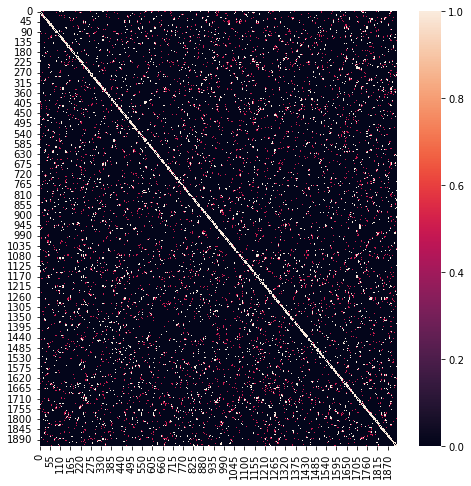

In [46]:
plt.figure(figsize=(8,8))
sns.heatmap(Xaff)

In [47]:
dim_labels      = ['LE'+str(i+1).zfill(3) for i in range(m)]
df              = pd.DataFrame(le, columns=dim_labels)
df.columns.name = 'LE dimensions'
df.index        = group_tvFC.columns
df.index.name   = 'Window Name'

In [48]:
plot_2d_scatter(df.reset_index(),x='LE001',y='LE002',c='Window Name',s=20)

:Scatter   [LE001]   (LE002,Window Name)

In [28]:
group_tvFC.std(axis=1)

ROI001  ROI000    1.000391
ROI002  ROI000    1.000391
        ROI001    1.000391
ROI003  ROI000    1.000391
        ROI001    1.000391
                    ...   
ROI156  ROI151    1.000391
        ROI152    1.000391
        ROI153    1.000391
        ROI154    1.000391
        ROI155    1.000391
Length: 12246, dtype: float64